<div align="center">

# NYU Agentic AI Workshop - Session 1

## Introduction to Agentic AI & Basic Tools

![HiAdi](media/hi_adi.gif)

</div>


<div align="center">

## About Your Instructor

<img src="media/amazon_bedrock_logo.png" width="400" style="display: inline-block; margin: 10px;" alt="AmazonBedrockLogo">
<img src="media/amazon_q.png" width="400" style="display: inline-block; margin: 10px;" alt="amazonq">

### I work here; But other than that—no relation to the workshop or its contents!

_This workshop uses OpenRouter and open-source tools_

Visit https://openrouter.ai/redeem and enter code `<redacted>`

</div>


---
---

---

<div align="center">

<br/>

## Who You Are (Based on Survey Results)

<img src="media/segments.png" width="800" alt="segments">

<img src="media/overview_agentic_experience.png" width="800" alt="overview_agentic_experience">

<img src="media/overview_python_experience.png" width="800" alt="overview_python_experience">

<img src="media/overview_program_status.png" width="800" alt="overview_program_status">

<img src="media/enthusiasm_and_depth.png" width="800" alt="enthusiasm_and_depth">

**Mixed experience levels** → Perfect for peer learning

**2 or so hours/week for your own practice** → Use the openrouter keys, get more out of the workshop with discussions

**Too technical + not technical enough** → Come to office hours! Link on website

</div>


<div align="center">

## The "Agentic AI" Hype

### Let's check the buzz at the bottom of the [Workshop Website](http://adityasinghal.com/agentic-ai-workshop)

<img src="media/ai_hype.png" width="800" alt="ai_hype">

</div>


---
---

---

<div align="center">

<br/>

# The Evolution of AI Capabilities

## Era 1: "Wow, it talks back" - January 2021

<img src="media/early_days.png" width="800" alt="early_days">

(Pretty sure this was RoBERTa) Revolutionary but often nonsensical. We were amazed it could complete sentences!

## Era 2: "Wow, it makes sense" - December 2022

<img src="media/chatgpt_early_free_dec22.png" width="800" alt="chatgpt_early_free_dec22">

ChatGPT changed everything. Coherent, helpful conversations. This is what most of you have used, since.

## Era 3: "Wow, it 'perceives'" - March 2023

<img src="media/chatgpt_multimodal_march23.png" width="800" alt="chatgpt_multimodal_march23">

Multimodal capabilities: Now it could see images, understand charts, process documents.

## Era 4: "Wow, it can take actions" - May 2024

<img src="media/claude_tool_use_may24.png" width="800" alt="claude_tool_use_may24">

### 🎯 THIS is where things get AGENTIC!

Not just talking, but DOING. From understanding to action. This is our focus.

</div>


---

# Let's Start Coding!

## First: Basic LLM Calls

We'll build from the ground up, starting with simple LLM invocation.


In [1]:
# Environment Setup
import os
import sys
import json
import time
import asyncio
from datetime import datetime
from typing import Dict, List, Optional, Any

# Load environment variables
import dotenv

dotenv.load_dotenv()

# For making HTTP requests
import httpx

# API Configuration
API_URL = "https://openrouter.ai/api/v1/chat/completions"
HEADERS = {
    "Authorization": f"Bearer {os.getenv('OPENROUTER_API_KEY')}",
    "Content-Type": "application/json",
}
DEFAULT_MODEL = "anthropic/claude-3.5-haiku"
DEFAULT_TEMPERATURE = 0.7
DEFAULT_MAX_TOKENS = 2048
TIMEOUT = 60.0

print("✅ Environment ready!")
print(f"📍 Using model: {DEFAULT_MODEL}")
print(f"🔑 API key loaded: {'Yes' if os.getenv('OPENROUTER_API_KEY') else 'No'}")

✅ Environment ready!
📍 Using model: anthropic/claude-3.5-haiku
🔑 API key loaded: Yes


## The Anatomy of an LLM Call


In [2]:
def invokeModel(prompt: str, model: str = DEFAULT_MODEL) -> str:
    """Simple synchronous LLM invocation."""
    response = httpx.post(
        API_URL,
        headers=HEADERS,
        json={"model": model, "messages": [{"role": "user", "content": prompt}]},
        timeout=TIMEOUT,
    )
    return response.json()["choices"][0]["message"]["content"]


def parseSSE(response, handler):
    """Parse Server-Sent Events for streaming responses."""
    buffer = ""
    for chunk in response.iter_text():
        buffer += chunk
        while "\n" in buffer:
            line, buffer = buffer.split("\n", 1)
            if line.startswith("data: "):  # SSE data line
                data = line[6:]
                if data == "[DONE]":
                    return
                try:
                    handler(json.loads(data))
                except:
                    pass


def invokeModelStream(prompt: str, model: str = DEFAULT_MODEL):
    """Stream tokens as they arrive for better UX."""
    with httpx.stream(
        "POST",
        API_URL,
        headers=HEADERS,
        json={
            "model": model,
            "messages": [{"role": "user", "content": prompt}],
            "stream": True,
            "temperature": DEFAULT_TEMPERATURE,
            "max_output_tokens": DEFAULT_MAX_TOKENS,
        },
        timeout=TIMEOUT,
    ) as response:
        parseSSE(
            response,
            lambda data: (
                print(
                    data["choices"][0]["delta"].get("content", ""), end="", flush=True
                )
                if "choices" in data
                else None
            ),
        )


print("✅ LLM functions defined!")

✅ LLM functions defined!


## The Fundamental Limitation

Let's ask the LLM something it can't know:


In [3]:
PROMPT = "What time is it right now? Be specific with hours, minutes, and seconds. Bullet point response"

invokeModelStream(PROMPT)

I apologize, but I cannot actually tell you the current time. As an AI, I do not have real-time access to the current time. To get the precise current time, you can:

• Check a digital clock
• Look at your computer or phone's time display
• Use an online time website
• Check a physical clock in your environment

## From Chat to Agent: Adding Tools

Now let's give the LLM the ability to check the time by calling Python functions!


In [4]:
# Define tool functions - just regular Python!
def get_current_time():
    """Tool function that returns current time with seconds."""
    now = datetime.now()
    return f"Current time: {now.strftime('%I:%M:%S %p on %A, %B %d, %Y')}"


def get_current_day():
    """Tool function that returns current day of the week."""
    now = datetime.now()
    return f"Today is {now.strftime('%A, %B %d, %Y')}"


# Test our tools locally
print("Testing tools:")
print(f"  - {get_current_time()}")
print(f"  - {get_current_day()}")

Testing tools:
  - Current time: 04:27:39 PM on Saturday, October 04, 2025
  - Today is Saturday, October 04, 2025


In [5]:
# Define tool schemas in the open router format which uses the OpenAI function calling spec
# We need this because we don't want to do any "smart stuff" on the model's outputs
# let the model do its own smart stuff and give us exact params

TIME_TOOL = {
    "type": "function",
    "function": {
        "name": "get_current_time",
        "description": "Get the current time with seconds",
        "parameters": {"type": "object", "properties": {}},
    },
}

DAY_TOOL = {
    "type": "function",
    "function": {
        "name": "get_current_day",
        "description": "Get the current day of the week",
        "parameters": {"type": "object", "properties": {}},
    },
}

print("✅ Tool schemas defined!")
print("📋 Available tools: get_current_time, get_current_day")

✅ Tool schemas defined!
📋 Available tools: get_current_time, get_current_day


In [6]:
# Implement tool calling with conversation memory

conversation_history = []


def invokeModelWithTools(prompt, tools=None, model=DEFAULT_MODEL):
    """Tool calling with streaming final response and conversation memory."""
    global conversation_history
    tools_map = {
        "get_current_time": get_current_time,
        "get_current_day": get_current_day,
    }

    # Add new user message to history
    conversation_history.append({"role": "user", "content": prompt})

    # Step 1: Get tool calls
    response = httpx.post(
        API_URL,
        headers=HEADERS,
        json={"model": model, "messages": conversation_history, "tools": tools},
        timeout=TIMEOUT,
    ).json()

    assistant_msg = response["choices"][0]["message"]
    conversation_history.append(assistant_msg)

    # Step 2: Execute tool calls
    if assistant_msg.get("tool_calls"):
        for tool_call in assistant_msg["tool_calls"]:
            tool_name = tool_call["function"]["name"]
            print(f"> 🔧 Calling tool: {tool_name}")
            if tool_name in tools_map:
                result = tools_map[tool_name]()
                conversation_history.append(
                    {"role": "tool", "tool_call_id": tool_call["id"], "content": result}
                )

    # Step 3: Stream final response
    final_content = ""

    def capture_content(data):
        nonlocal final_content
        content = data["choices"][0]["delta"].get("content", "")
        final_content += content
        print(content, end="", flush=True)

    with httpx.stream(
        "POST",
        API_URL,
        headers=HEADERS,
        json={
            "model": model,
            "messages": conversation_history,
            "tools": tools,
            "stream": True,
        },
        timeout=TIMEOUT,
    ) as response:
        parseSSE(response, capture_content)

    # Add final response to history
    conversation_history.append({"role": "assistant", "content": final_content})
    print()


print("✅ Tool calling implemented!")

✅ Tool calling implemented!


## Moment of Magic: Our First Agent!

Watch as the LLM uses tools to answer questions it couldn't before:


In [7]:
# Loop to show the agent in action
prompt = (
    "Greet me with on sentence based on the time of day and tell me the exact time including seconds. "
    "Never greet me the same way twice. Keep greetings simple. BE FACTUAL, NEVER LIE"
)

for i in range(3):
    print(f"\n{'='*50}")
    print(f"🔄 Iteration {i+1}")
    print(f"{'='*50}\n")

    invokeModelWithTools(prompt, [TIME_TOOL, DAY_TOOL])

print("\n💡 Key Observations:")
print("  1. Different greetings each time (context awareness)")
print(
    "  2. Accurate time that advances (real tool calls) = 'looks at a clock' all by itself'"
)
print("  3. Didn't use day tool (intelligent selection)")
print("  4. This is a LOOP that adapts - the essence of agents!")


🔄 Iteration 1

> 🔧 Calling tool: get_current_time
Good afternoon! The precise time right now is 04:27:40 PM.

🔄 Iteration 2

> 🔧 Calling tool: get_current_time
Warmest wishes for a pleasant late afternoon at precisely 04:27:43 PM!

🔄 Iteration 3

> 🔧 Calling tool: get_current_time
Hoping your afternoon is going smoothly at exactly 04:27:45 PM!

💡 Key Observations:
  1. Different greetings each time (context awareness)
  2. Accurate time that advances (real tool calls) = 'looks at a clock' all by itself'
  3. Didn't use day tool (intelligent selection)
  4. This is a LOOP that adapts - the essence of agents!


---

# The Integration Nightmare

## Every Platform Wants It Different

This works great... until you need to use your tools on different platforms. Let's see the problem:


In [8]:
# A simple weather function - our core business logic
def fetch_weather_data(city: str) -> str:
    """The actual weather fetching logic - identical everywhere."""
    # Using wttr.in for simple weather data
    try:
        response = httpx.get(f"http://wttr.in/{city}?format=j1", timeout=5.0)
        data = response.json()
        current = data["current_condition"][0]
        return f"Weather in {city}: {current['weatherDesc'][0]['value']}, {current['temp_F']}°F"
    except:
        return f"Could not get weather for {city}"


# Test it
print("🌤️  Testing our weather function:")
print(fetch_weather_data("New York"))

🌤️  Testing our weather function:
Weather in New York: Sunny, 81°F


## The Same Tool, Three Different Wrappers


In [9]:
# 1. OpenAI Function Calling Format
def openai_weather_integration():
    return [
        {
            "type": "function",
            "function": {
                "name": "get_weather",
                "description": "Get current weather for a city",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "city": {"type": "string", "description": "City name"}
                    },
                    "required": ["city"],
                },
            },
        }
    ]


# 2. Anthropic Tool Use Format
def anthropic_weather_integration():
    return [
        {
            "name": "get_weather",
            "description": "Get current weather for a city",
            "input_schema": {
                "type": "object",
                "properties": {"city": {"type": "string", "description": "City name"}},
                "required": ["city"],
            },
        }
    ]


# 3. LangChain/Custom Framework Format
class CustomWeatherTool:
    def __init__(self):
        self.name = "get_weather"
        self.description = "Get current weather for a city"

    def get_schema(self):
        return {
            "type": "object",
            "properties": {"city": {"type": "string"}},
            "required": ["city"],
        }

    def invoke(self, city: str) -> str:
        return fetch_weather_data(city)


print("THREE DIFFERENT WAYS TO DO THE SAME THING!\n")
print("\n💭 Imagine maintaining this across 10 tools and 5 platforms...")
print("That's 50 different integrations to keep in sync!\n")

THREE DIFFERENT WAYS TO DO THE SAME THING!


💭 Imagine maintaining this across 10 tools and 5 platforms...
That's 50 different integrations to keep in sync!



# Wanting to share a charger with a friend on a road trip

## (I've been an Android user all my life)

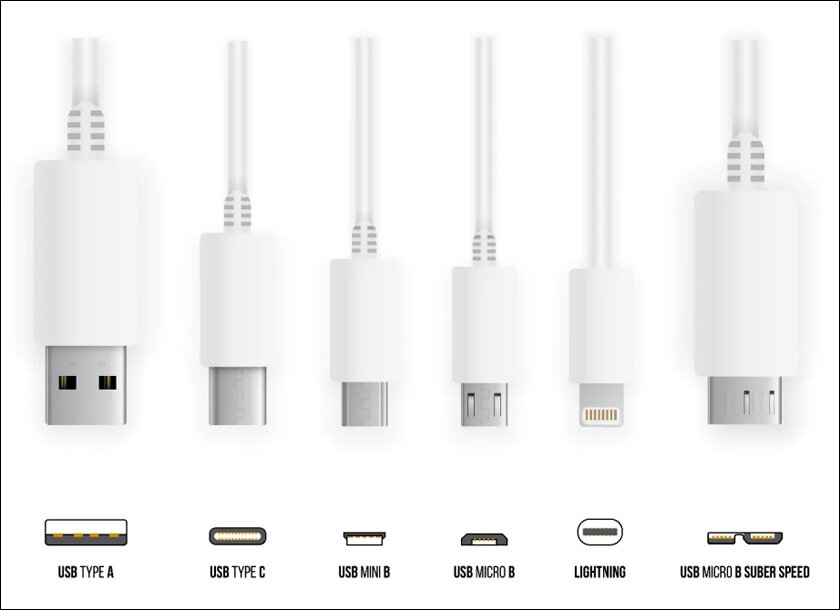


---
---

---

<br/>

# Enter MCP: The USB-C of AI Tools

## One Standard, Many Clients

Model Context Protocol (MCP) solves this by creating a single standard that all AI clients can use.

### After MCP:

```json
{
  "servers": {
    "weather-mcp-server": {
      "command": "python",
      "args": ["weather-server.py"]
    }
  }
}
```

**Same config works in:**

- ✅ GitHub Copilot
- ✅ Cursor
- ✅ Claude Desktop
- ✅ FastAgent
- ✅ Any MCP-compatible client!

It's like USB-C: One port design, works with a vape pen and also a laptop

But also MCP != tool use just like USB-C != charging


In [10]:
file_path = "../src/server/weather_server.py"
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# The Python code you want to write to the file
python_code = """#!/usr/bin/env python3

import requests
from fastmcp import FastMCP
from fastmcp.utilities.logging import get_logger

# Initialize logger for server lifecycle events
logger = get_logger(__name__)


# ============= MCP SERVER INITIALIZATION =============

# Create FastMCP instance with comprehensive configuration
mcp = FastMCP(
    name="weather-mcp-server",
    instructions="You are a weather assistant",
)


@mcp.tool()
def fetch_weather_data(city: str) -> str:
    url = f"http://wttr.in/{city}?format=j1"
    try:
        response = requests.get(url, timeout=5)
        data = response.json()
        current = data["current_condition"][0]
        return f"Weather in {city}: {current['weatherDesc'][0]['value']}, {current['temp_F']}°F"
    except Exception:
        return f"Could not get weather for {city}"


# ============= SERVER ENTRY POINT =============

if __name__ == "__main__":
    mcp.run()
"""

with open(file_path, "w") as f:
    f.write(python_code)

print(f"File created successfully at: {file_path}")

File created successfully at: ../src/server/weather_server.py


<div align="center">

## The Restaurant Analogy

Host = Restaurant Manager: The notebook cell, CoPilot

Client = Waiters: The MCP client that copilot has implemented following specs and using public MCP SDKs

Server = Kitchen: What we made via FastMCP which made following specs easy (FastMCP now ships along with the official python MCP SDK too)

LLM = Newly hired Head Chef (Claude!)

<img src="media/analogy_v2.png" width="800" alt="analogy_v2">

</div>


<div align="center">

<img src="media/mcp_illustration_1_main_message_flow_v2.png" width="1000" alt="mcp_illustration_1_main_message_flow_v2">

</div>


---

## Let's build something!

### Vision - Email response agent!

```python
# MCP Server - Email Tools
@mcp_tool
def read_emails(folder="inbox", limit=10):
    return email_client.fetch_unread(folder, limit)

@mcp_tool
def draft_response(email_id, response_text):
    return email_client.create_draft(email_id, response_text)

@mcp_tool
def send_email(draft_id):
    return email_client.send(draft_id)


# Agent Loop
tools = [read_emails, draft_response, send_email]
conversation_history = []

while True:
    # LLM decides what to do
    response = llm.chat(
        messages=conversation_history,
        tools=tools,
        system="You are an email assistant. Read emails and draft responses."
    )

    if response.tool_calls:
        for tool_call in response.tool_calls:
            result = mcp.execute_tool(tool_call)
            conversation_history.append(result)

    sleep(300)
```

---

---

---


In [11]:
from ipywidgets import Button, Label, VBox, HBox
from IPython.display import display

cases = [
    (
        "H&M virtual shopping assistant for customer queries",
        "YES",
        "Strong fit! Supposedly led to 70% query resolution, acceptable errors, requires emphasis on different tools per session",
    ),
    (
        "JPMorgan legal contract data extraction",
        "YES",
        "Excellent! Supposedly saved 360K hours annually, requires data correlation from diff sources",
    ),
    (
        "Bank real-time fraud detection",
        "NO",
        "Too slow! Need rule-based for ultra-low latency",
    ),
    (
        "Hospital clinical support analyzing medical literature",
        "Maybe??",
        "Implies human oversight for high-value decisions",
    ),
    (
        "Autonomous loan approvals without human review",
        "NO",
        "Dangerous! High-stakes + bias risks need human-in-loop",
    ),
    (
        "IBM IT incident correlation across infrastructure",
        "YES",
        "Perfect! Supposedly 60% faster resolution, high complexity",
    ),
    (
        "Nuclear plant autonomous reactor safety management",
        "NO",
        "Life-critical! Zero error tolerance = human control",
    ),
    (
        "Claude/Cursor for code traversal and writing",
        "YES",
        "Excellent! Unpredictable tasks, many actions, high value",
    ),
]

score = 0
current = 0

title = Label(
    value="🤖 AGENT FIT OR FLOP? 🤖", style={"font_weight": "bold", "font_size": "20px"}
)
score_label = Label(value="Score: 0/0", style={"font_size": "14px"})
case_label = Label(value=f"Case 1/{len(cases)}:\n{cases[0][0]}")
feedback = Label(value="")

yes_btn = Button(
    description="✅ YES",
    button_style="success",
    layout={"width": "150px", "height": "40px"},
)
no_btn = Button(
    description="❌ NO",
    button_style="danger",
    layout={"width": "150px", "height": "40px"},
)


def check(answer):
    global score, current
    correct, reason = cases[current][1], cases[current][2]

    if answer == correct:
        feedback.value = f"✅ CORRECT! {reason}"
        score += 1
    else:
        feedback.value = f"❌ WRONG! Answer: {correct} - {reason}"

    current += 1
    score_label.value = f"Score: {score}/{current}"

    if current < len(cases):
        case_label.value = f"Case {current+1}/{len(cases)}:\n\n{cases[current][0]}"
    else:
        final = (
            "🏆 Agent Expert!"
            if score >= 7
            else "👍 Good!" if score >= 5 else "📚 Study more!"
        )
        case_label.value = ""
        feedback.value = f"🎯 GAME OVER! Final Score: {score}/{len(cases)}\n\n{final}"
        yes_btn.disabled = no_btn.disabled = True


yes_btn.on_click(lambda b: check("YES"))
no_btn.on_click(lambda b: check("NO"))

display(
    VBox(
        [
            title,
            score_label,
            case_label,
            HBox([yes_btn, no_btn], layout={"justify_content": "center"}),
            feedback,
        ],
        layout={"align_items": "center", "padding": "15px"},
    )
)

---
---

---

<br/>

<div align="center">

# Our Project: The Personalized Newspaper Agent 📰

## The Vision

**"I want a personalized newspaper delivered to me for my 30-minute train commute."**

-> Aggregates news from multiple sources

-> Filters by my interests

-> Creates a beautiful, readable format

-> Emails it to me

Let's build this step by step!

</div>


---

# Building Our MCP Server

## Phase 1: Basic Tools and Discoverability

Let's start with some tools for our newspaper agent


In [12]:
# First, let's import FastMCP
from fastmcp import FastMCP, Context
from pydantic import BaseModel, Field
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
import nest_asyncio

nest_asyncio.apply()

from src.server.services.http_client import BaseHTTPClient

HN_API_BASE = "https://hacker-news.firebaseio.com/v0"
HN_WEBSITE_BASE = "https://news.ycombinator.com"


class HackerNewsClient(BaseHTTPClient):
    async def get_story_ids(self, endpoint: str, count: int) -> list[int]:
        async def _fetch():
            async with httpx.AsyncClient(**self.client_config) as client:
                response = await client.get(f"{HN_API_BASE}/{endpoint}.json")
                response.raise_for_status()
                return response.json()[:count]  # Limit to requested count

        try:
            ids = await _fetch()
            print(f"Fetched {len(ids)} story IDs from {endpoint}")
            return ids
        except Exception as e:
            print(f"Failed to fetch story IDs from {endpoint}: {e}")
            raise

    async def get_item(self, item_id: int) -> Optional[dict]:
        async def _fetch():
            async with httpx.AsyncClient(**self.client_config) as client:
                response = await client.get(f"{HN_API_BASE}/item/{item_id}.json")
                response.raise_for_status()
                return response.json()

        try:
            item = await _fetch()
            if item:
                print(f"Fetched item {item_id}: {item.get('type', 'unknown')}")
            return item
        except Exception as e:
            print(f"Failed to fetch item {item_id}: {e}")
            return None


# Create our MCP server instance
mcp_v1 = FastMCP(
    name="newspaper-agent-server-v1",
)


@mcp_v1.tool()
# get hacker news stories
async def ghn(count) -> str:
    """
    Fetch top 'count' stories from Hacker News and format as markdown."""
    if not 1 <= count <= 150:
        raise ValueError("Count must be between 1 and 150")

    client = HackerNewsClient()

    # Fetch story IDs from top stories endpoint
    story_ids = await client.get_story_ids("topstories", count)

    # Fetch detailed story information
    stories = []
    for story_id in story_ids:
        story = await client.get_item(story_id)
        if story and story.get("title"):
            stories.append(
                {
                    "title": story["title"],
                    "score": story.get("score", 0),
                    "url": story.get("url", f"{HN_WEBSITE_BASE}/item?id={story_id}"),
                }
            )

    # Format as markdown with numbered list
    result = f"# Top {len(stories)} Hacker News Stories\n\n"
    for i, story in enumerate(stories, 1):
        result += f"{i}. **{story['title']}** ({story['score']} points)\n"
        result += f"   {story['url']}\n\n"

    return result

In [14]:
mcp_v2 = FastMCP(
    name="newspaper-agent-server-v1",
    instructions="Server for fetching top Hacker News stories",
)


@mcp_v2.tool()
async def fetch_hacker_news_stories(count: int = 5) -> str:
    """
    Fetch top stories from Hacker News with titles, scores, and URLs.

    Retrieves the most popular current stories from Hacker News,
    formatted as a markdown list with essential metadata.

    Args:
        count: Number of stories to fetch (1-150)
        ctx: FastMCP context (injected automatically)

    Returns:
        str: Markdown formatted list of top HN stories with titles, scores, and URLs

    Raises:
        ValueError: If count is outside valid range (1-150)
    """
    # Validate input parameters
    if not 1 <= count <= 150:
        raise ValueError("Count must be between 1 and 150")

    client = HackerNewsClient()

    # Fetch story IDs from top stories endpoint
    story_ids = await client.get_story_ids("topstories", count)

    # Fetch detailed story information
    stories = []
    for story_id in story_ids:
        story = await client.get_item(story_id)
        if story and story.get("title"):
            stories.append(
                {
                    "title": story["title"],
                    "score": story.get("score", 0),
                    "url": story.get("url", f"{HN_WEBSITE_BASE}/item?id={story_id}"),
                }
            )

    # Format as markdown with numbered list
    result = f"# Top {len(stories)} Hacker News Stories\n\n"
    for i, story in enumerate(stories, 1):
        result += f"{i}. **{story['title']}** ({story['score']} points)\n"
        result += f"   {story['url']}\n\n"

    return result

```bash

▎◀ News Agent ────────────────────────────────────────────────[tool request - fetch_hacker_news_stories]

{'count': 20}

─| fetch_hacke… | fetch |───────────────────────────────────────────────────────────────────────────────


▎▶ News Agent ──────────────────────────────────────────────────────[tool result - Text Only 2452 chars]

# Top 20 Hacker News Stories

1. **Claude Sonnet 4.5** (875 points)
   https://www.anthropic.com/news/claude-sonnet-4-5

2. **California governor signs AI transparency bill into law** (117 points)
   https://www.gov.ca.gov/2025/09/29/governor-newsom-signs-sb-53-advancing-californias-world-leading-artificial-intelligence-industry/

3. **Claude Code 2.0** (423...


▎▶ News Agent ──────────────────────────────────────────────────────[tool result - Text Only 3165 chars]

Contents of https://www.anthropic.com/news/claude-sonnet-4-5:
Claude Sonnet 4.5 is the best coding model in the world. It's the strongest model for building complex agents.
It’s the best model at using computers. And it shows substantial gains in reasoning and math.

Code is everywhere. It runs every application, spreadsheet, and software tool you use. Being...

▎▶ News Agent ─────────────────────────────────────────────────────────────────────[tool result - ERROR]

Failed to fetch https://openai.com/index/buy-it-in-chatgpt/ - status code 403
```


---

### We can't assume clients will use a specified server provided by someone else, plus we are getting rejected from some sites


In [15]:
from html_to_markdown import convert_to_markdown
from typing import Dict

from src.server.config.constants import DEFAULT_HEADERS


async def fetch(url):
    retries = 2
    async with httpx.AsyncClient(headers=DEFAULT_HEADERS, timeout=120) as client:
        for attempt in range(1, retries + 1):
            try:
                resp = await client.get(url)
                resp.raise_for_status()
                return convert_to_markdown(resp.text)[:5000]
            except httpx.HTTPError as exc:
                if attempt == retries:
                    raise
                await asyncio.sleep(0.5 * attempt)


@mcp_v2.tool()
async def fetch_content(url: str) -> str:
    """
    Fetch HTML from `url` and convert to Markdown.

    Args:
        url: The target URL.
        headers: HTTP headers to spoof a real browser.
        timeout: Request timeout in seconds.
        retries: Number of retry attempts on failure.

    Returns:
        Markdown-converted text.

    Raises:
        httpx.HTTPError: On request failure after retries.
    """
    return await fetch(url)

## Phase 2: The "Always Together" Problem

Some tools are always called together. Let's see this problem and fix it:


In [16]:
@mcp_v2.prompt(name="Detailed Newspaper Request")
async def ask_for_proper_detailed_newspaper() -> str:
    """Prompt for quick newspaper request"""
    return "Please make me a detailed newspaper by pulling 30 HN articles, ranking them all by how interesting they are and then fetching content for them all and summarizing them for me with broad themes at the top."

In [17]:
mcp_v3 = FastMCP(
    name="newspaper-agent-server-v1",
    instructions="Server for fetching top Hacker News stories",
)


@mcp_v3.prompt(name="Detailed Newspaper Request")
async def ask_for_proper_detailed_newspaper() -> str:
    """Prompt for quick newspaper request"""
    return "Please make me a detailed newspaper by pulling 30 HN articles, ranking them all by how interesting they are and summarizing them for me with broad themes at the top."


@mcp_v3.tool()
async def fetch_hacker_news_stories_and_contents(count: int = 5) -> str:
    """
    Fetch top stories from Hacker News with titles, scores, and URLs.

    Retrieves the most popular current stories from Hacker News,
    formatted as a markdown list with essential metadata.

    Args:
        count: Number of stories to fetch (1-150)
        ctx: FastMCP context (injected automatically)

    Returns:
        str: Markdown formatted list of top HN stories with titles, scores, and URLs

    Raises:
        ValueError: If count is outside valid range (1-150)
    """
    # Validate input parameters
    if not 1 <= count <= 150:
        raise ValueError("Count must be between 1 and 150")

    client = HackerNewsClient()

    # Fetch story IDs from top stories endpoint
    story_ids = await client.get_story_ids("topstories", count)

    # Fetch detailed story information
    stories = []
    for story_id in story_ids:
        story = await client.get_item(story_id)
        if story and story.get("title"):
            url = story.get("url", f"{HN_WEBSITE_BASE}/item?id={story_id}")
            content = await fetch(url)
            stories.append(
                {
                    "title": story["title"],
                    "score": story.get("score", 0),
                    "url": url,
                    "content": content,
                    # "content": content[:5000]
                }
            )

    # Format as markdown with numbered list
    result = f"# Top {len(stories)} Hacker News Stories\n\n"
    for i, story in enumerate(stories, 1):
        result += f"{i}. **{story['title']}** ({story['score']} points)\n"
        result += f"   {story['url']}\n\n"
        result += f"   {story['content']}\n\n"

    return result

---
```bash
🏆 STORY RANKINGS BY INTEREST LEVEL       

TIER S: Breakthrough Territory ⭐⭐⭐

#1 - Claude Sonnet 4.5 Launch (938 points) Anthropic's latest model claims to be the world's best coding model and strongest for building agents. This represents a potential paradigm shift in AI 
capabilities, especially for autonomous systems and computer use.                                                         

#2 - FCC Accidentally Leaked iPhone Schematics (205 points) A rare peek behind Apple's curtain due to regulatory mishap. The leak potentially exposes company secrets to competitors, highlighting 
the tension between transparency requirements and trade secrets.
```
---

1. Would have been nice to get progress notifications
2. Who decides what's interesting?
3. Presentation of the newspaper


## Phase 3: Building the Full MCP Server

Now let's build our complete newspaper agent with all the tools we need!


In [18]:
# Cell: Phase 3 Imports and Setup
from pathlib import Path
from typing import Dict, List, Optional

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / "src" / "server"))

# Core MCP imports

warnings.filterwarnings("ignore", category=DeprecationWarning)

nest_asyncio.apply()

# Service imports
from services.email_service import EmailService
from services.interests_file import InterestsFileService

# Config imports
from config.settings import get_settings

print("✅ All Phase 3 imports successful!")
print(f"📁 Working directory: {Path.cwd()}")
print(f"📁 Server path: {Path.cwd().parent / 'src' / 'server'}")

✅ All Phase 3 imports successful!
📁 Working directory: /Users/adi/Documents/GitHub/agentic-ai-workshop-2025/notebooks
📁 Server path: /Users/adi/Documents/GitHub/agentic-ai-workshop-2025/src/server


In [19]:
# Cell: Application Context Setup
from contextlib import asynccontextmanager
from dataclasses import dataclass


@dataclass
class AppContext:
    """Application context with all services for newspaper creation."""

    hn_client: HackerNewsClient
    interests_service: InterestsFileService
    email_service: EmailService
    settings: object


@asynccontextmanager
async def app_lifespan(mcp: FastMCP):
    """Initialize all services for the newspaper agent."""
    print("🚀 Starting Newspaper Creation Agent MCP Server")

    # Get settings
    settings = get_settings()
    settings.data_dir.mkdir(parents=True, exist_ok=True)

    # Initialize all services
    hn_client = HackerNewsClient()
    interests_service = InterestsFileService(settings.data_dir)

    # Email service configuration
    email_service = EmailService(
        {
            "server": "smtp.gmail.com",
            "port": 587,
            "use_tls": True,
            "username": "adityaarunsinghal@gmail.com",
            "password": os.getenv("MCP_SMTP_PASSWORD", ""),
            "from_email": "adityaarunsinghal@gmail.com",
            "from_name": "Newspaper Creation Agent",
        }
    )

    print("✅ All services initialized!")
    print(f"📧 Email: {email_service.server}:{email_service.port}")
    print(f"📁 Data: {settings.data_dir}")

    try:
        yield AppContext(
            hn_client=hn_client,
            interests_service=interests_service,
            email_service=email_service,
            settings=settings,
        )
    finally:
        print("👋 Shutting down MCP Server")


print("✅ Application context manager defined!")

✅ Application context manager defined!


In [20]:
# Cell: MCP Server with Full Tool Suite

mcp = FastMCP(
    name="newspaper-creation-agent",
    instructions="""You are a sophisticated newspaper creation assistant.
    
    Your capabilities:
    - Fetch stories from Hacker News
    - Extract full article content from URLs
    - Track and manage user interests
    - Create structured newspapers with sections
    - Add articles to newspaper sections
    - Send finished newspapers via email
    
    Current date: {date}
    """.format(
        date=datetime.now().strftime("%A, %B %d, %Y")
    ),
    lifespan=app_lifespan,
)

# ============= CORE TOOLS =============


@mcp.tool()
async def fetch_hn_stories(count: int = 5, ctx: Context = None) -> str:
    """Fetch top stories from Hacker News."""
    if not 1 <= count <= 30:
        raise ValueError("Count must be between 1 and 30")

    client = ctx.request_context.lifespan_context.hn_client
    story_ids = await client.get_story_ids("topstories", count)

    stories = []
    for story_id in story_ids:
        story = await client.get_item(story_id)
        if story and story.get("title"):
            stories.append(
                {
                    "id": story_id,
                    "title": story["title"],
                    "score": story.get("score", 0),
                    "url": story.get("url", f"{HN_WEBSITE_BASE}/item?id={story_id}"),
                    "by": story.get("by", "unknown"),
                }
            )

    result = f"# Top {len(stories)} Hacker News Stories\n\n"
    for i, story in enumerate(stories, 1):
        result += (
            f"{i}. **{story['title']}** ({story['score']} points by {story['by']})\n"
        )
        result += f"   {story['url']}\n\n"

    return result


@mcp.tool()
async def fetch_article_content(url: str, ctx: Context = None) -> str:
    """Fetch and extract clean content from a web URL."""
    try:
        content = (await fetch(url))[:8000]
        return f"# Content from {url}\n\n{content}"
    except Exception as e:
        return f"❌ Failed to fetch {url}: {str(e)}"


# ============= NEWSPAPER CREATION TOOLS =============


@mcp.tool()
async def create_newspaper_draft(
    title: str = "Daily Tech Digest",
    subtitle: str = "",
    sections: List[str] = None,
    ctx: Context = None,
) -> str:
    """Create a new newspaper draft with sections."""
    if sections is None:
        sections = ["Top Stories", "Technology", "Analysis"]

    newspaper_id = f"newspaper_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    draft = {
        "id": newspaper_id,
        "title": title,
        "subtitle": subtitle,
        "created_at": datetime.now().isoformat(),
        "status": "draft",
        "sections": [{"title": sec, "articles": []} for sec in sections],
    }

    # Save draft
    settings = ctx.request_context.lifespan_context.settings
    drafts_dir = Path(settings.data_dir) / "newspapers"
    drafts_dir.mkdir(exist_ok=True)

    draft_file = drafts_dir / f"{newspaper_id}.json"
    with open(draft_file, "w") as f:
        json.dump(draft, f, indent=2)

    # Save HTML draft
    email_service = ctx.request_context.lifespan_context.email_service
    html_content = email_service._create_html_version(draft)
    html_file = drafts_dir / f"{newspaper_id}.html"
    with open(html_file, "w", encoding="utf-8") as f:
        f.write(html_content)

    result = f"# 📰 Newspaper Draft Created\n\n"
    result += f"**ID:** {newspaper_id}\n"
    result += f"**Title:** {title}\n"
    result += f"**Sections:** {', '.join(sections)}\n"
    result += f"**Files:** {draft_file}, {html_file}\n\n"
    result += f"*Use add_article_to_newspaper() to add content*"

    return result


@mcp.tool()
async def add_article_to_newspaper(
    newspaper_id: str,
    section: str,
    title: str,
    content: str,
    url: str = "",
    author: str = "",
    score: int = 10,
    ctx: Context = None,
) -> str:
    """Add an article to a newspaper section with importance score (1-100)."""
    settings = ctx.request_context.lifespan_context.settings
    draft_file = Path(settings.data_dir) / "newspapers" / f"{newspaper_id}.json"

    if not draft_file.exists():
        return f"❌ Newspaper '{newspaper_id}' not found"

    # Load draft
    with open(draft_file, "r") as f:
        draft = json.load(f)

    # Find section
    target_section = None
    for sec in draft["sections"]:
        if sec["title"].lower() == section.lower():
            target_section = sec
            break

    if not target_section:
        sections = [s["title"] for s in draft["sections"]]
        return f"❌ Section '{section}' not found. Available: {', '.join(sections)}"

    # Add article
    article = {
        "title": title,
        "content": content,
        "url": url,
        "author": author,
        "score": score,
        "added_at": datetime.now().isoformat(),
    }
    target_section["articles"].append(article)

    # Save JSON
    with open(draft_file, "w") as f:
        json.dump(draft, f, indent=2)

    # Update HTML
    email_service = ctx.request_context.lifespan_context.email_service
    html_content = email_service._create_html_version(draft)
    html_file = draft_file.with_suffix(".html")
    with open(html_file, "w", encoding="utf-8") as f:
        f.write(html_content)

    total_articles = sum(len(s["articles"]) for s in draft["sections"])

    return f"✅ Added '{title}' to {section}\nTotal articles: {total_articles}"


@mcp.tool()
async def send_newspaper_email(newspaper_id: str, ctx: Context = None) -> str:
    """Send the finished newspaper via email."""
    settings = ctx.request_context.lifespan_context.settings
    draft_file = Path(settings.data_dir) / "newspapers" / f"{newspaper_id}.json"

    if not draft_file.exists():
        return f"❌ Newspaper '{newspaper_id}' not found"

    # Load draft
    with open(draft_file, "r") as f:
        draft = json.load(f)

    # Get email service
    email_service = ctx.request_context.lifespan_context.email_service

    # Send email
    result = email_service.send_newspaper(
        newspaper_data=draft, subject=f"📰 {draft['title']}"
    )

    if result.get("success"):
        return f"✅ Newspaper '{draft['title']}' sent successfully!\n\n{result.get('message', '')}"
    else:
        return f"❌ Failed to send: {result.get('error', 'Unknown error')}"


@mcp.tool()
async def preview_newspaper(newspaper_id: str, ctx: Context = None) -> str:
    """Preview newspaper before sending."""
    settings = ctx.request_context.lifespan_context.settings
    draft_file = Path(settings.data_dir) / "newspapers" / f"{newspaper_id}.json"

    if not draft_file.exists():
        return f"❌ Newspaper '{newspaper_id}' not found"

    with open(draft_file, "r") as f:
        draft = json.load(f)

    result = f"# 📰 {draft['title']}\n"
    if draft.get("subtitle"):
        result += f"*{draft['subtitle']}*\n"
    result += f"\n{datetime.now().strftime('%A, %B %d, %Y')}\n\n"

    for section in draft["sections"]:
        if not section["articles"]:
            continue

        result += f"## {section['title']}\n\n"
        for i, article in enumerate(section["articles"], 1):
            result += f"### {i}. {article['title']}\n"
            if article.get("author"):
                result += f"*By {article['author']}*\n\n"

            # Preview first 200 chars
            preview = article["content"][:200]
            if len(article["content"]) > 200:
                preview += "..."
            result += f"{preview}\n\n"

            if article.get("url"):
                result += f"[Read more]({article['url']})\n\n"
            result += "---\n\n"

    return result


print("✅ All newspaper creation tools registered!")

✅ All newspaper creation tools registered!


### Checking articles on: https://mail.google.com/mail/u/0/#search/%22Generated+by+Newspaper+Creation+Agent%22

In [21]:
# Cell: Resources and Prompts
@mcp.resource("file://interests.md")
async def get_interests_file(ctx: Context = None) -> str:
    """User's interests file."""
    interests_service = ctx.request_context.lifespan_context.interests_service
    interests = interests_service.read_interests()

    result = "# Your Interests\n\n"
    result += f"**Last Updated:** {interests.get('last_updated', 'Unknown')}\n\n"

    topics = interests.get("topics", [])
    if topics:
        result += "## Topics\n"
        for topic in topics:
            result += f"- {topic}\n"

    return result


@mcp.prompt()
async def create_quick_newspaper() -> str:
    """Workflow for creating a quick 5-article newspaper."""
    return """Create a quick newspaper with these steps:

1. fetch_hn_stories(count=10) - Get recent stories
2. create_newspaper_draft(title="Tech Brief", sections=["Headlines", "Deep Dive"])
3. For 2-3 interesting stories:
   - fetch_article_content(url) to get full content
   - add_article_to_newspaper() with summary
4. preview_newspaper() to review
5. send_newspaper_email() to deliver

Keep it concise and focused!"""


@mcp.prompt()
async def create_comprehensive_newspaper() -> str:
    """Workflow for creating a detailed newspaper."""
    return """Create a comprehensive newspaper:

1. fetch_hn_stories(count=20) - Get more options
2. create_newspaper_draft(
    title="Daily Tech Digest",
    sections=["Top Stories", "Technology", "Analysis", "Opinion"]
   )
3. For 8-10 stories across different sections:
   - fetch_article_content(url)
   - Summarize intelligently
   - add_article_to_newspaper() to appropriate section
4. preview_newspaper() for final review
5. send_newspaper_email() to deliver

Aim for depth and variety!"""


print("✅ Resources and prompts registered!")

✅ Resources and prompts registered!


<div align="center">

## Adding Resources and Prompts

MCP servers can provide resources (like files) and prompts (workflow templates):


<img src="media/mcp_illustration_2_resources_prompts_isolation_v2.png" width="1000" alt="mcp_illustration_2_resources_prompts_isolation_v2">

</div>


In [22]:
# Add prompts - these are like chef's specials!
@mcp.prompt()
async def create_morning_newspaper() -> str:
    """Workflow for creating a morning newspaper.

    Like a prix fixe menu - a curated experience!
    """
    return """Create a comprehensive morning newspaper by:

1. Fetch top stories from Hacker News (fetch_hn_stories)
2. Search for content matching my interests (search_by_interests)
3. Fetch full content for the most relevant articles (fetch_content)
4. Create a newspaper with all content (create_newspaper)
5. Organize into logical sections
6. Ensure each section has 2-3 articles

Make it perfect for a 30-minute commute read!
"""


@mcp.prompt()
async def deep_interest_research() -> str:
    """Deep research based on interests.

    ⚠️ This prompt will cause context overflow! (Intentional for teaching)
    """
    return """For EACH interest in my interests.md file:

1. Search extensively for related content
2. Fetch at least 5 articles per interest
3. Read the full content of each article
4. Find related articles from those articles
5. Create comprehensive summaries
6. Build a mega-newspaper with everything

I want DEEP coverage of each topic. Don't stop until you have 
at least 20 articles total, with full content for each!

This should be incredibly thorough!
"""

In [ ]:
os.system("lsof -ti:8080 | xargs kill -9 2>/dev/null")
await mcp.run_async(transport="streamable-http", port=8080)

╭────────────────────────────────────────────────────────────────────────────╮
│                                                                            │
│        _ __ ___  _____           __  __  _____________    ____    ____     │
│       _ __ ___ .'____/___ ______/ /_/  |/  / ____/ __ \  |___ \  / __ \    │
│      _ __ ___ / /_  / __ `/ ___/ __/ /|_/ / /   / /_/ /  ___/ / / / / /    │
│     _ __ ___ / __/ / /_/ (__  ) /_/ /  / / /___/ ____/  /  __/_/ /_/ /     │
│    _ __ ___ /_/    \____/____/\__/_/  /_/\____/_/      /_____(*)____/      │
│                                                                            │
│                                                                            │
│                                FastMCP  2.0                                │
│                                                                            │
│                                                                            │
│               🖥️  Server name:     newspaper-agent-server-v1                │
│               📦 Transport:       Streamable-HTTP                          │
│               🔗 Server URL:      http://127.0.0.1:8080/mcp                │
│                                                                            │
│               🏎️  FastMCP version: 2.12.3                                   │
│               🤝 MCP SDK version: 1.14.1                                   │
│                                                                            │
│               📚 Docs:            https://gofastmcp.com                    │
│               🚀 Deploy:          https://fastmcp.cloud                    │
│                                                                            │
╰────────────────────────────────────────────────────────────────────────────╯

[10/04/25 16:27:48] INFO     Starting MCP server 'newspaper-agent-server-v1' with transport          ]8;id=193205;file:///Users/adi/Documents/GitHub/agentic-ai-workshop-2025/.venv/lib/python3.13/site-packages/fastmcp/server/server.py\server.py]8;;\:]8;id=104662;file:///Users/adi/Documents/GitHub/agentic-ai-workshop-2025/.venv/lib/python3.13/site-packages/fastmcp/server/server.py#1572\1572]8;;\
                             'streamable-http' on http://127.0.0.1:8080/mcp                                        

INFO:     Started server process [47253]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8080 (Press CTRL+C to quit)
INFO:     Shutting down
ERROR:    Cancel 0 running task(s), timeout graceful shutdown exceeded
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [47253]


## If we had used the lower level MCP python SDK, our code would have been something like this:

```python
"""
Low-level MCP SDK translation of newspaper-agent-server
"""
import asyncio
from typing import Any

import mcp.server.stdio
import mcp.types as types
from mcp.server.lowlevel import NotificationOptions, Server
from mcp.server.models import InitializationOptions

# Create server instance
server = Server("newspaper-agent-server-v1")


# ============================================================================
# PROMPT HANDLERS
# ============================================================================

@server.list_prompts()
async def list_prompts() -> list[types.Prompt]:
    """List available prompts - replaces @mcp.prompt() decorator"""
    return [
        types.Prompt(
            name="Detailed Newspaper Request",
            description="Prompt for quick newspaper request",
            arguments=[],  # No arguments for this prompt
        )
    ]


@server.get_prompt()
async def get_prompt(name: str, arguments: dict[str, str] | None) -> types.GetPromptResult:
    """Handle prompt requests - executes the prompt logic"""
    if name == "Detailed Newspaper Request":
        message_text = (
            "Please make me a detailed newspaper by pulling 30 HN articles, "
            "ranking them all by how interesting they are and summarizing them "
            "for me with broad themes at the top."
        )
        return types.GetPromptResult(
            description="Prompt for detailed newspaper request",
            messages=[
                types.PromptMessage(
                    role="user",
                    content=types.TextContent(
                        type="text",
                        text=message_text
                    )
                )
            ]
        )
    else:
        raise ValueError(f"Unknown prompt: {name}")


# ============================================================================
# TOOL HANDLERS
# ============================================================================

@server.list_tools()
async def list_tools() -> list[types.Tool]:
    """List available tools - replaces @mcp.tool() decorator registration"""
    return [
        types.Tool(
            name="fetch_hacker_news_stories_and_contents",
            description=(
                "Fetch top stories from Hacker News with titles, scores, and URLs. "
                "Retrieves the most popular current stories from Hacker News, "
                "formatted as a markdown list with essential metadata."
            ),
            inputSchema={
                "type": "object",
                "properties": {
                    "count": {
                        "type": "integer",
                        "description": "Number of stories to fetch (1-150)",
                        "default": 5,
                        "minimum": 1,
                        "maximum": 150
                    }
                },
                "required": []  # count has a default, so it's optional
            }
        )
    ]


@server.call_tool()
async def call_tool(name: str, arguments: dict[str, Any]) -> list[types.TextContent | types.ImageContent | types.EmbeddedResource]:
    """Handle tool calls - replaces @mcp.tool() decorated function execution"""
    
    if name == "fetch_hacker_news_stories_and_contents":
        # Extract arguments with defaults
        count = arguments.get("count", 5)
        
        # Validate input parameters
        if not 1 <= count <= 150:
            raise ValueError("Count must be between 1 and 150")

        client = HackerNewsClient()

        # Fetch story IDs from top stories endpoint
        story_ids = await client.get_story_ids("topstories", count)

        # Fetch detailed story information
        stories = []
        for story_id in story_ids:
            story = await client.get_item(story_id)
            if story and story.get("title"):
                url = story.get("url", f"{HN_WEBSITE_BASE}/item?id={story_id}")
                content = await fetch(url)
                stories.append({
                    "title": story["title"],
                    "score": story.get("score", 0),
                    "url": url,
                    "content": content,
                })

        # Format as markdown with numbered list
        result = f"# Top {len(stories)} Hacker News Stories\n\n"
        for i, story in enumerate(stories, 1):
            result += f"{i}. **{story['title']}** ({story['score']} points)\n"
            result += f"   {story['url']}\n\n"
            result += f"   {story['content']}\n\n"

        # Return as TextContent (low-level requires specific content types)
        return [types.TextContent(type="text", text=result)]
    
    else:
        raise ValueError(f"Unknown tool: {name}")


# ============================================================================
# SERVER RUNNER
# ============================================================================

async def run():
    """Run the MCP server with stdio transport"""
    async with mcp.server.stdio.stdio_server() as (read_stream, write_stream):
        await server.run(
            read_stream,
            write_stream,
            InitializationOptions(
                server_name="newspaper-agent-server-v1",
                server_version="1.0.0",
                capabilities=server.get_capabilities(
                    notification_options=NotificationOptions(),
                    experimental_capabilities={},
                ),
            ),
        )


if __name__ == "__main__":
    asyncio.run(run())
```

---
# Cliffhanger for Session 2:

- Semantic compression
- Memory systems (short vs long-term)
- Context management strategies
- Smart summarization
- Tool result caching

---

# Homework & Next Steps

## Required (for participation):
1. **Think of one agentic use case** relevant to your work/research
2. **Write it down** - we'll discuss next session

## Encouraged (for learning):
1. **Run this notebook** end-to-end
2. **Implement 2 new tools** for your use case
3. **Document what worked** and what didn't
4. **Try connecting tools** together

## For the Ambitious:
- Some of you worried this wouldn't be technical enough... 
- Build a complex tool (database integration, API calls)
- Create tool compositions
- Implement your own mini-agent

## Resources:
- This notebook: Available immediately
- Full server code: In the repository
- Office hours: Friday 5pm ET

## Session 2 Preview:
- **Context Management**: How to handle infinite content
- **Memory Systems**: Short-term vs long-term
- **Elicitation**: Getting info from users
- **Sampling**: Using LLMs within tools
- **Production Patterns**: What works in the real world

## Session 4 Reminder:
**Showcase Day!** We'll all share what we built and learn from each other.

---

# Thank You! 🎉


**See you next week for Session 2!**
